# *IN THE NAME OF GOD*

### *Load Dataset From Kaggle*

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [2]:
api_token = {"username":"mpyahyazadeh","key":"e7185a8edfd31216e4aa7f59e82701cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d anshulmehtakaggl/chess-pieces-detection-images-dataset

Dataset URL: https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset
License(s): CC0-1.0
chess-pieces-detection-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/chess-pieces-detection-images-dataset.zip -d data

Archive:  /content/chess-pieces-detection-images-dataset.zip
  inflating: data/Queen-Resized/00000000_resized.jpg  
  inflating: data/Queen-Resized/00000001_resized.jpg  
  inflating: data/Queen-Resized/00000003_resized.jpg  
  inflating: data/Queen-Resized/00000004_resized.jpg  
  inflating: data/Queen-Resized/00000005_resized.jpg  
  inflating: data/Queen-Resized/00000007_resized.jpg  
  inflating: data/Queen-Resized/00000008_resized.jpg  
  inflating: data/Queen-Resized/00000010_resized.jpg  
  inflating: data/Queen-Resized/00000011_resized.jpg  
  inflating: data/Queen-Resized/00000012_resized.jpg  
  inflating: data/Queen-Resized/00000013_resized.jpg  
  inflating: data/Queen-Resized/00000014_resized.jpg  
  inflating: data/Queen-Resized/00000015_resized.jpg  
  inflating: data/Queen-Resized/00000017_resized.jpg  
  inflating: data/Queen-Resized/00000018_resized.jpg  
  inflating: data/Queen-Resized/00000021_resized.jpg  
  inflating: data/Queen-Resized/00000022_resized.jpg  
  in

# *Preproccesing and Visualization*

In [9]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Path to the new chess dataset
dir1 = '/content/data'

# Detect class folders (each representing a chess piece)
detection = [class_name for class_name in os.listdir(dir1) if os.path.isdir(os.path.join(dir1, class_name))]

print(detection)

['Queen-Resized', 'Rook-resize', 'bishop_resized', 'knight-resize', 'pawn_resized']


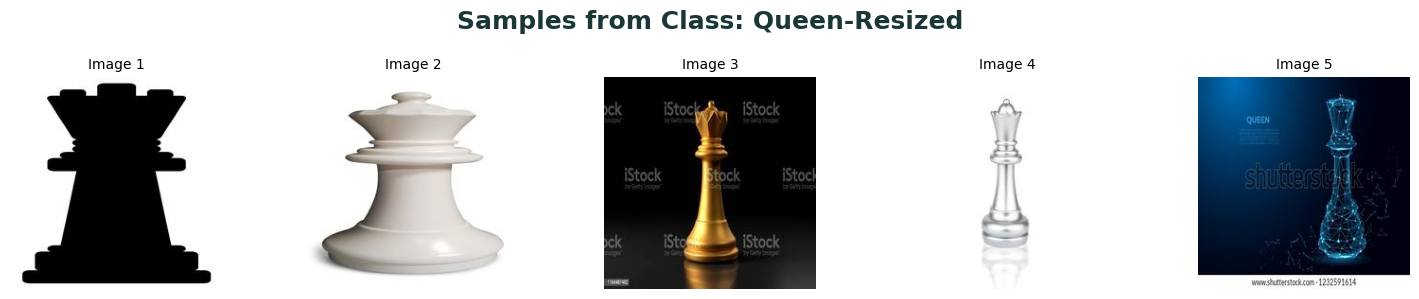

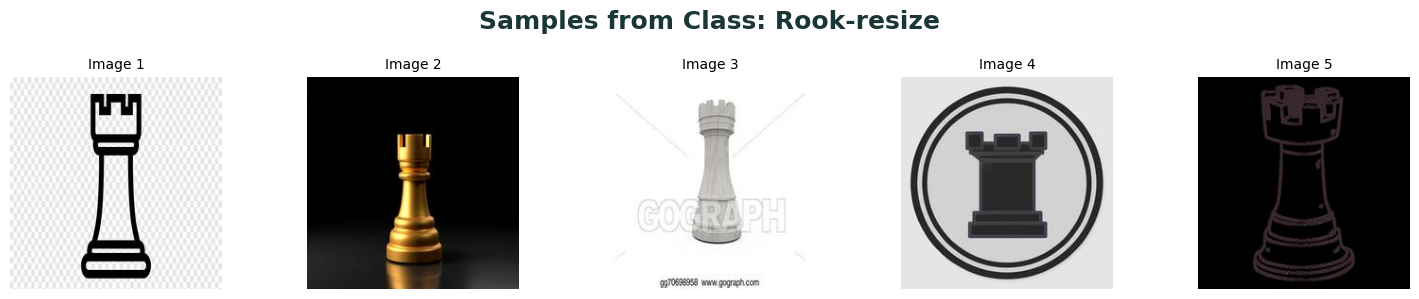

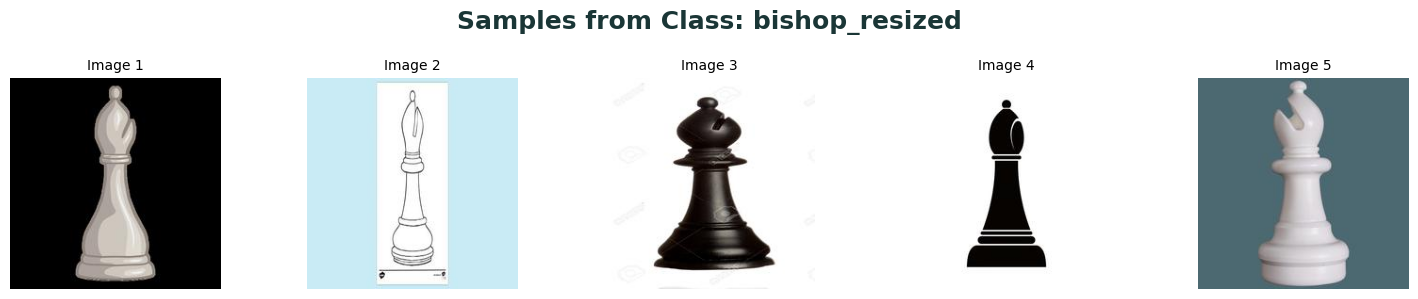

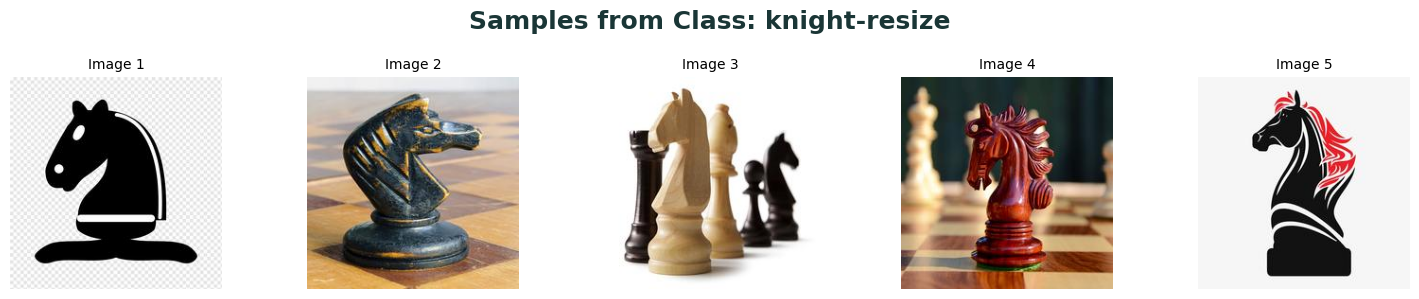

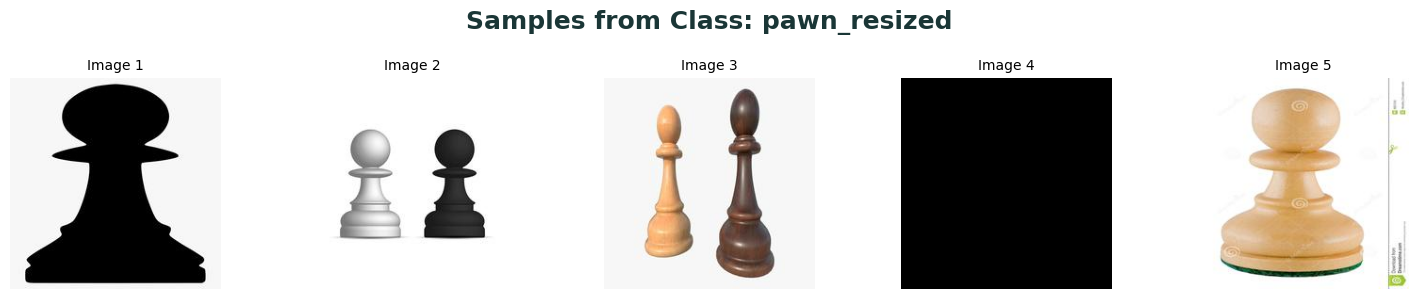

In [14]:
# Plot and Count Images
for class_name in detection:
    # Prepare class path
    class_path = os.path.join(dir1, class_name)
    # List images
    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)

    # Create a figure with improved aesthetics
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(f'Samples from Class: {class_name}', fontsize=18, fontweight='bold', color='#1A3636')

    for i in range(5):
        # Load and display the image
        img_path = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')  # Remove axis

        # Optionally, add image title
        ax[i].set_title(f'Image {i + 1}', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()  # Display the figure

In [12]:
# Path to the dataset
dir1 = '/content/data'

# Dictionary to hold image counts per class
class_image_counts = {}

# Loop through each class folder
for class_name in os.listdir(dir1):
    class_path = os.path.join(dir1, class_name)
    if os.path.isdir(class_path):
        # Count only files (assuming all are images)
        image_count = len([
            file for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        ])
        class_image_counts[class_name] = image_count

# Print the results
for class_name, count in class_image_counts.items():
    print(f"{class_name}: {count} images")

Queen-Resized: 115 images
Rook-resize: 139 images
bishop_resized: 141 images
knight-resize: 174 images
pawn_resized: 82 images


In [18]:
from collections import Counter

image_shapes = []

for class_name in os.listdir(dir1):
    class_path = os.path.join(dir1, class_name)
    if not os.path.isdir(class_path): continue
    for img_file in os.listdir(class_path):
        if img_file.endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(class_path, img_file))
            image_shapes.append(img.size)

shape_counts = Counter(image_shapes)
print("Image shapes and their counts:")
for shape, count in shape_counts.items():
    print(f"{shape}: {count}")

Image shapes and their counts:
(224, 224): 651


# *Data Augmentation With Tensorflow*


In [33]:
import tensorflow as tf
import os
import random
from tensorflow.keras import layers

# Dataset path
data_dir = "/content/data"

# Parameters
img_size = (224, 224)
batch_size = 32
seed = 42

# Define augmentation pipeline (rescaling last!)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomBrightness(factor=0.2),
    layers.Rescaling(1./255)  # Normalize after augmentation
])

# Get all image paths
all_image_paths = []
class_names = sorted(os.listdir(data_dir))

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_image_paths.append(os.path.join(class_path, fname))

# Shuffle and split
random.seed(seed)
random.shuffle(all_image_paths)

total = len(all_image_paths)
train_count = int(0.7 * total)
val_count = int(0.2 * total)

train_paths = all_image_paths[:train_count]
val_paths = all_image_paths[train_count:train_count + val_count]
test_paths = all_image_paths[train_count + val_count:]

# Get label from path
def get_label(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]

# Decode image only (no normalization here)
def decode_img(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img, label


# Prepare dataset and apply augmentation only to training
def prepare_dataset(file_paths, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=1000)

    # Convert string labels to numerical using class_names
    def to_numerical_labels(image, label):
        return image, tf.argmax(label == class_names)

    ds = ds.map(to_numerical_labels)  # Add this line

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_ds = prepare_dataset(train_paths, augment=True)
val_ds = prepare_dataset(val_paths)
test_ds = prepare_dataset(test_paths)


In [34]:
len(train_ds), len(val_ds), len(test_ds)

(15, 5, 3)

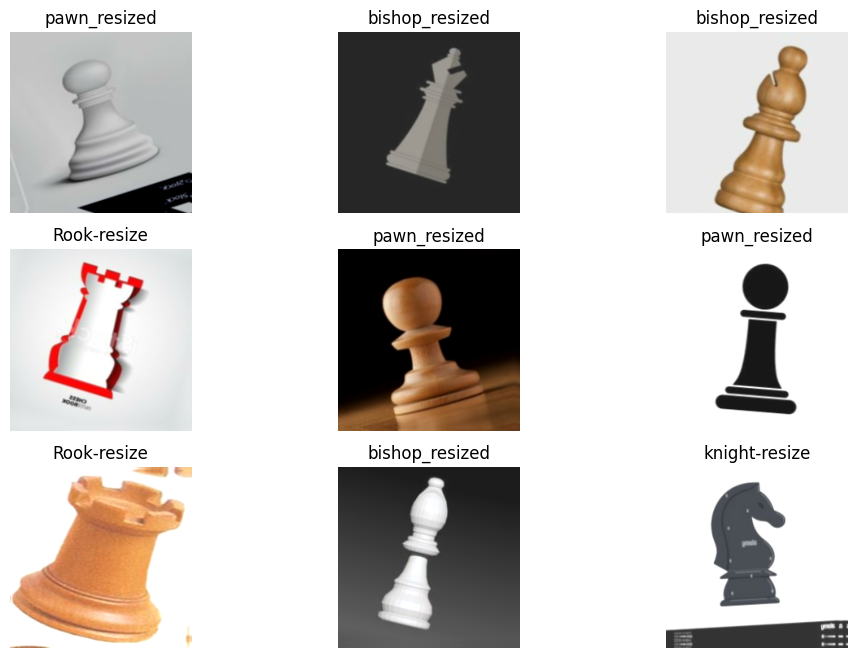

In [28]:
import matplotlib.pyplot as plt

# Get a batch from the dataset
class_names = sorted(os.listdir(data_dir))  # ensure labels are ordered
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):  # show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())

        # Get the class name as a string
        class_name = labels[i].numpy().decode('utf-8')

        # Find the index of the class name in the class_names list
        class_index = class_names.index(class_name)

        plt.title(class_names[class_index]) # Use the index to access the class name
        plt.axis("off")
    break
plt.show()

# *Modeling : Pretrained MobileNetV2*

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Number of classes
num_classes = len(class_names)

# Pretrained base model (without top/classification head)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # use sparse if labels are integer-encoded
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3132 - loss: 1.7372 - val_accuracy: 0.6154 - val_loss: 0.9715
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6368 - loss: 0.9400 - val_accuracy: 0.6846 - val_loss: 0.7883
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7671 - loss: 0.7112 - val_accuracy: 0.7077 - val_loss: 0.7025
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8186 - loss: 0.5617 - val_accuracy: 0.7846 - val_loss: 0.5697
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8289 - loss: 0.4996 - val_accuracy: 0.7615 - val_loss: 0.5632
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8409 - loss: 0.4003 - val_accuracy: 0.7923 - val_loss: 0.5201
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8405 - loss: 0.4056 - val_accuracy: 0.8000 - val_loss: 0.5136
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8377 - loss: 0.3880 - val_accuracy: 0.7462 - val_loss:

# *Evaluate and Test Pretrained Model*

<ipython-input-58-d38912408f01>:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-58-d38912408f01>:31: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


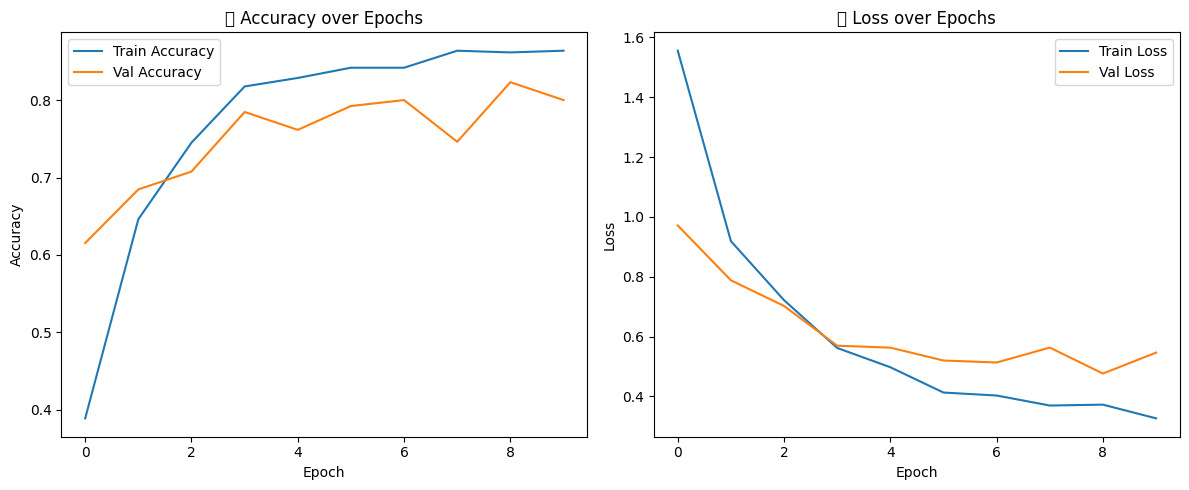

In [58]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('📈 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('📉 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 898ms/step - accuracy: 0.7693 - loss: 0.6488
Validation Accuracy: 0.8000, Loss: 0.5466


In [47]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 705ms/step - accuracy: 0.6727 - loss: 1.1385
Test Accuracy: 0.6970, Loss: 1.0613


In [48]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
                precision    recall  f1-score   support

 Queen-Resized       0.70      0.82      0.76        17
   Rook-resize       0.86      0.86      0.86        14
bishop_resized       0.53      0.57      0.55        14
 knight-resize       0.70      0.78      0.74         9
  pawn_resized       0.71      0.42      0.53        12

      accuracy                           0.70        66
     macro avg       0.70      0.69      0.69        66
  weighted avg       0.70      0.70      0.69        66



In [54]:
import pandas as pd
from tabulate import tabulate

In [55]:
# Convert result of training to a df
result_df = pd.DataFrame(history.history)
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+------------+----------+----------------+------------+
|    |   accuracy |     loss |   val_accuracy |   val_loss |
|----+------------+----------+----------------+------------|
|  0 |   0.389011 | 1.55568  |       0.615385 |   0.971478 |
|  1 |   0.646154 | 0.919146 |       0.684615 |   0.788305 |
|  2 |   0.745055 | 0.72183  |       0.707692 |   0.702478 |
|  3 |   0.817582 | 0.562083 |       0.784615 |   0.569661 |
|  4 |   0.828571 | 0.497678 |       0.761538 |   0.563237 |
|  5 |   0.841758 | 0.413079 |       0.792308 |   0.52013  |
|  6 |   0.841758 | 0.403198 |       0.8      |   0.513577 |
|  7 |   0.863736 | 0.369729 |       0.746154 |   0.563368 |
|  8 |   0.861538 | 0.372676 |       0.823077 |   0.476561 |
|  9 |   0.863736 | 0.326893 |       0.8      |   0.546613 |
+----+------------+----------+----------------+------------+


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


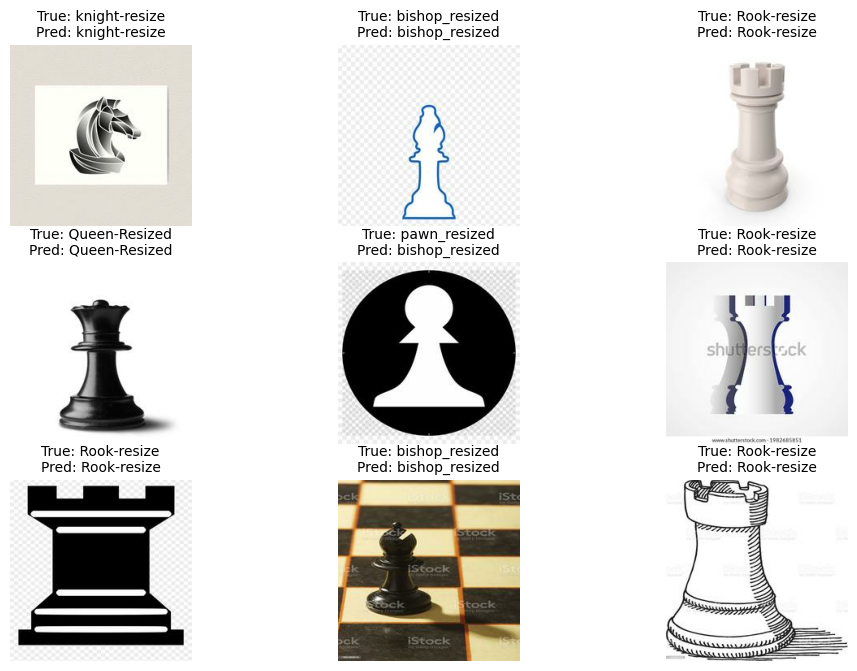

In [50]:
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        true_lbl = class_names[int(labels[i])]
        pred_lbl = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", fontsize=10)
        plt.axis("off")